## Example of dislib model upload to mlflow

It uses docker to run dislib (image can be found in dislibimage), build it with

```
   docker build . -t mydislib
```

and start with:

```
   docker run -p 8888:8888 -v `pwd`:/notebooks/ mydislib
```

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression

import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import pycompss.interactive as ipycompss

In [6]:
import mlflow
import mlflow.pyfunc

class PyCompssWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, md):
        super().__init__()
        self.model = md
        
    def predict(self, context, model_input):
        return self.model.predict(model_input)
    
    @staticmethod
    def get_pip():
        return [f"pycomps", f"dislib=={ds.__version__}"]

In [7]:
#ipycompss.start(graph=True, monitor=1000)
ipycompss.start(graph=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           ______         ___      *
*         :         )         |____  \       /   |     *
*   .~ ~ -.\       /.- ~~ .      __) |      /_/| |     *
*   >       `.   .'       <     |__  |         | |     *
*  (         .- -.         )   ____) |   _     | |     *
*   `- -.-~  `- -'  ~-.- -'   |______/  |_|    |_|     *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

In [8]:
from dislib.cluster import KMeans
import dislib as ds
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [9]:
mlflow.set_tracking_uri('https://zam10017.zam.kfa-juelich.de/')
mlflow.set_experiment('dislib-tests-clean')

<Experiment: artifact_location='mlflow-artifacts:/5', creation_time=1680077947468, experiment_id='5', last_update_time=1680077947468, lifecycle_stage='active', name='dislib-tests-clean', tags={}>

In [10]:
x, y = make_blobs(n_samples=1500)

x_ds = ds.array(x, block_size=(500, 2))

In [11]:
mlflow.end_run()

In [12]:
mlflow.start_run()

<ActiveRun: >

In [13]:
km = KMeans(n_clusters=3)
mlflow.log_param('k', value=3)

km.fit(x_ds)
y_pred = km.predict(x_ds)
centers = km.centers

#log model
wrapped = PyCompssWrapper(km)
model_info = mlflow.pyfunc.log_model(artifact_path='dislibmodel', 
                                         python_model=wrapped, 
                                         pip_requirements=PyCompssWrapper.get_pip() )

<IPython.core.display.Javascript object>

INFO: The ERRMGR displayed some error or warnings.


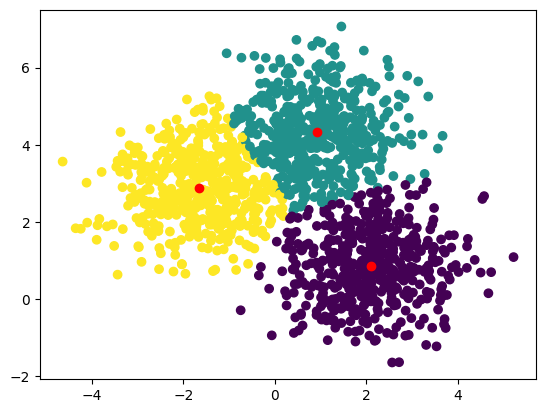

In [14]:
fig, axs = plt.subplots(1)
axs.scatter(x[:, 0], x[:, 1], c=y_pred.collect())
axs.scatter(centers[:, 0], centers[:, 1], c='red')
#log figure
mlflow.log_figure(fig, 'centers.png')

In [15]:
# log compss config
mlflow.log_artifacts('../xml/')

In [16]:
ipycompss.stop()

********************************************************
*************** STOPPING PyCOMPSs ******************
********************************************************
Checking if any issue happened.
         have not been brought to the master.
********************************************************


In [17]:
mlflow.end_run()